### KMeans Clustering of Netflix Movie Data for CSCI6370  Dr. Lei HanSheng

Project Leader: Steven Bowler  UTRGV  20562494
Project Git Repo: [Netflix Study](https://github.com/stevenbowler/netflixstudy)

Current State of Analysis:   The full dataframe/matrix df_p is loaded here but due to its size, 144380 x 5334, KMeans clustering took 24+ hours and did not finish; therefore, to prove out the KMeans below, used df_p_short which just has the first 1,000 rows of df_p.   Then for display of the 5 clusters at the bottom of this file, used heatmaps of 70 users x 50 movies.

Next steps:    Evaluating cloud options: Google, AWS, Azure; to acquire necessary processing and memory to handle the full dataset.

Attribution: Used helper function to display heat map [from here](https://programming.rhysshea.com/K-means_movie_ratings/)

Next Steps: Evaluating use of collaborative filtering to create recommender table, something like [this](https://github.com/anjanatiha/Movie-Recommendation-Engine-using-User-Based-Collaborative-Filtering)

Need to fire up Jupyter with this to be able to load df_p with its almost 700MM nodes:

<font color=red>jupyter notebook --NotbookApp.iopub_Data_Rate_Limit=1e10

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix

In [2]:
df_p = pd.read_csv('../data/processed/df_p.csv')

In [6]:
df_p_short = df_p.head(1000)

In [7]:
df_p_short

,Cust_Id,3,8,16,17,18,26,28,30,33,...,17741,17743,17751,17756,17758,17761,17762,17763,17764,17769
0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18426,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
996,18432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,5.0,NaN
997,18475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,18517,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# sparse_ratings = csr_matrix(pd.DataFrame(df_p).sparse.to_coo())   
sparse_ratings = csr_matrix(df_p_short.values)

In [9]:
sparse_ratings.shape

(1000, 5333)

In [10]:
# convert to int to stop crashing in KMeans
sparse_ratings_int = sparse_ratings.astype(int)

In [11]:
predictions = KMeans(n_clusters=5, algorithm='full').fit_predict(sparse_ratings_int)

In [26]:
# %load ../src/features/rating_helper.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score


def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# plots clusters (with colour) based on the predictions made using the fit_predict method


def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([biased_dataset.reset_index(),
                           pd.DataFrame({'group': predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'],
                clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)


def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg


def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster])
              for row, cluster in zip(data, predictions)]
    return sum(errors)


def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre)]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, [
            'userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat(
            [genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings


def get_dataset_3(movies, ratings, genre_ratings):
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action')]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, [
        'userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat(
        [genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_romance_rating',
                               'avg_scifi_rating', 'avg_action_rating']

    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_romance_rating'] < b1 - 0.2) & (genre_ratings_3['avg_scifi_rating'] > b2)) | (
        (genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())

    return biased_dataset_3


def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat(
        [biased_dataset_3.reset_index(), pd.DataFrame({'group': predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)


def draw_movie_clusters(clustered, max_users, max_movies):
    c = 1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(
            ['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]

        d = sort_by_rating_density(d, max_movies, max_users)

#         d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)   # commented out by SB 20oct2020
#         d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster),
                  '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15, 4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]), minor=False)
            ax.set_xticks(np.arange(d.shape[1]), minor=False)

            ax.set_xticklabels(labels, minor=False)

            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(
                ['5 stars', '4 stars', '3 stars', '2 stars', '1 stars', '0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off',
                            top='off', left='off', labelbottom='off', labelleft='off')
            # print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break


def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(
        user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(
        len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(
        user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:,
                                                       :max_number_of_movies]
    return most_rated_movies


def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values(
        'counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop([
                                                                               'counts'], axis=1)

    return most_rated_movies_users_selection


def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies


def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,
                        interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(
            np.arange(most_rated_movies_users_selection.shape[0]), minor=False)
        ax.set_xticks(
            np.arange(most_rated_movies_users_selection.shape[1]), minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(
            most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(
        ['5 stars', '4 stars', '3 stars', '2 stars', '1 stars', '0 stars'])

    plt.show()

    # breaks the data up so we don't have both genres highly rates, more like one or the other


def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2))
                                   | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset


In [25]:
# import recommendation_helper   #  used %load above

cluster # 3
# of users in cluster: 208. # of users in plot: 70


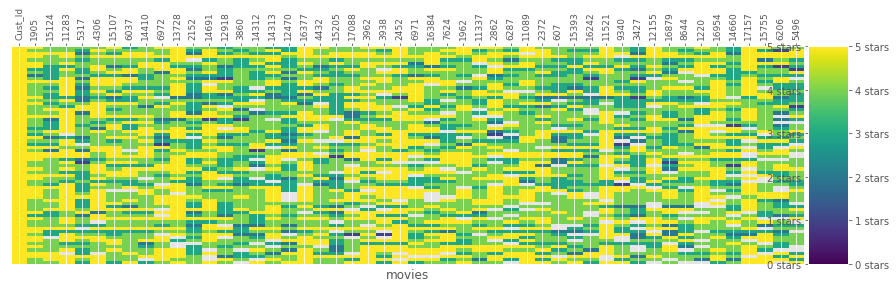

cluster # 2
# of users in cluster: 89. # of users in plot: 70


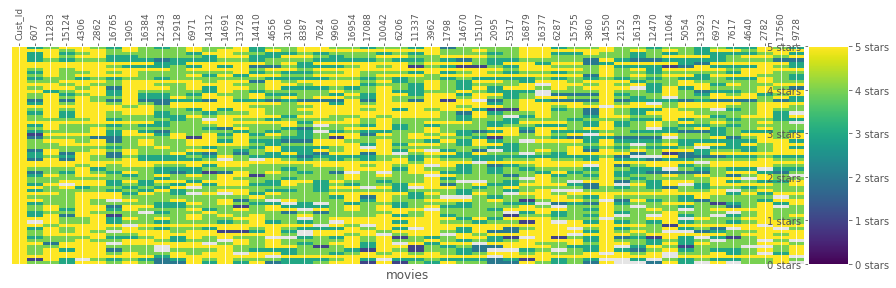

cluster # 1
# of users in cluster: 544. # of users in plot: 70


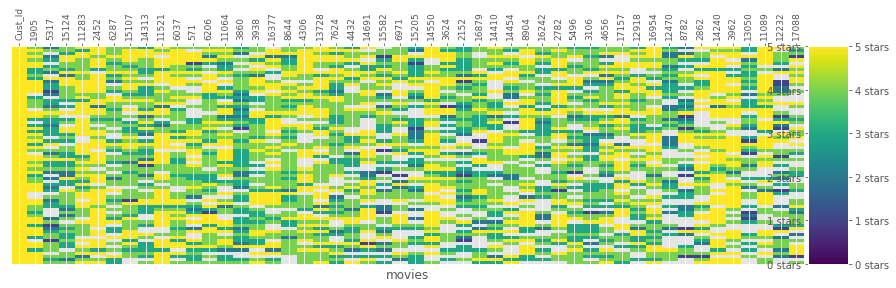

cluster # 0
# of users in cluster: 146. # of users in plot: 70


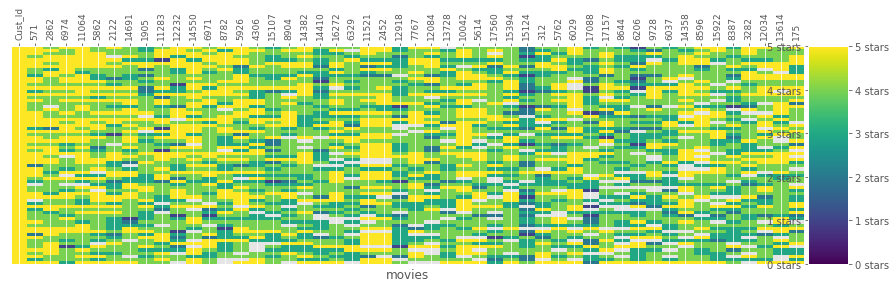

cluster # 4
# of users in cluster: 13. # of users in plot: 13


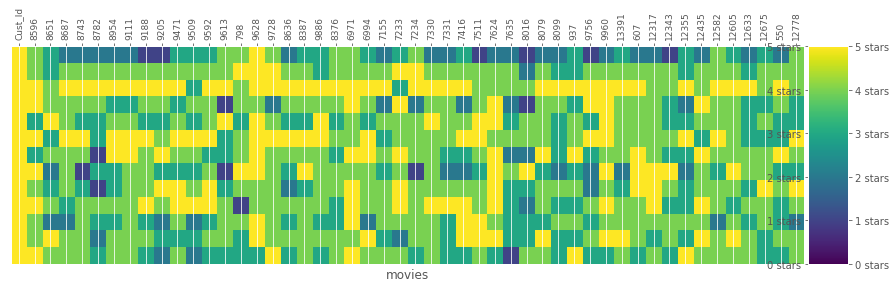

In [27]:
max_users = 70
max_movies = 50

# not sure use df_p or sparse_ratings
clustered = pd.concat([df_p_short.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# helper.draw_movie_clusters(clustered, max_users, max_movies)
draw_movie_clusters(clustered, max_users, max_movies)